In [67]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import datetime

import random

%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [68]:
# # The below is necessary for starting Numpy generated random numbers
# # in a well-defined initial state.

np.random.seed(123)

# # The below is necessary for starting core Python generated random numbers
# # in a well-defined state.

random.seed(123)

# # The below set_seed() will make random number generation
# # in the TensorFlow backend have a well-defined initial state.
# # For further details, see:

# # https://www.tensorflow.org/api_docs/python/tf/random/set_seed

tf.random.set_seed(1234)

In [69]:
# Clear any logs from previous runs
# rm -rf ./data/logs/

In [70]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 30

In [71]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "../augmented_data/Train",
    seed = 123,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 4000 files belonging to 4 classes.


In [72]:
class_names = dataset.class_names
class_names

['Blotch_Apple', 'Normal_Apple', 'Rot_Apple', 'Scab_Apple']

In [73]:
# len(dataset)

In [74]:
testset = tf.keras.preprocessing.image_dataset_from_directory(
    "../augmented_data/Test",
    seed = 123,
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 120 files belonging to 4 classes.


In [75]:
class_names = testset.class_names
class_names

['Blotch_Apple', 'Normal_Apple', 'Rot_Apple', 'Scab_Apple']

In [76]:
# len(testset)

In [77]:
# plt.figure(figsize=(10, 10)) # om dimensies totale afbeelding aan te passen en tekst leesbaar te houden
# for image_batch, label_batch in dataset.take(1): # toont at random afbeeldingen uit de dataset
#     # print(image_batch.shape)
#     # print(label_batch.numpy())
#     # print(image_batch[0].numpy)
#     # print(image_batch[0].shape)
#     for i in range(12):
#         ax = plt.subplot(3, 4, i+1)    
#         # plt.imshow(image_batch[0].numpy().astype("uint8"))
#         # plt.title(class_names[label_batch[0]])
#         plt.imshow(image_batch[i].numpy().astype("uint8")) # met [i] ipv [0] wordt de loop doorlopen en 12 afb. getoond
#         plt.title(class_names[label_batch[i]])
#         plt.axis("off") # om extra informatie (> assen) uit te zetten

In [78]:
# plt.figure(figsize=(10, 10)) # om dimensies totale afbeelding aan te passen en tekst leesbaar te houden
# for image_batch, label_batch in testset.take(1): # toont at random afbeeldingen uit de dataset
#     for i in range(12):
#         ax = plt.subplot(3, 4, i+1)    
#         plt.imshow(image_batch[i].numpy().astype("uint8")) 
#         plt.title(class_names[label_batch[i]])
#         plt.axis("off") 

In [79]:
train_size = 0.8
len(dataset)*train_size

100.0

In [80]:
train_ds = dataset.take(9) # met .take() worden de eerste (x) batches geslecteerd
len(train_ds)

9

In [81]:
# test_ds = dataset.skip() # met .skip() worden er overgeslagen
# omdat we een aparte folder voor de test-dataset hebben, kunnen we deze als onderstaand inladen
test_ds = testset
len(test_ds) # lengte in batches

4

In [82]:
val_size = 0.2
len(dataset)*val_size

25.0

In [83]:
val_ds = dataset.skip(9)
len(val_ds)

116

In [84]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.2, shuffle=True, shuffle_size=10000):

    assert (train_split + val_split) == 1 # test_split niet want extra folder

    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    # test_ds = ds.skip(train_size).skip(val_size) # als we de test-dataset ook uit dezelfde batch/folder zouden halen
    test_ds = testset
        
    return train_ds, val_ds, test_ds

In [85]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [86]:
# len(train_ds)

In [87]:
# len(val_ds)

In [88]:
# len(test_ds)

In [89]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE) ## bij CPU én GPU gebruik.
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [90]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)    
])

In [91]:
# data_augmentation = tf.keras.Sequential([
#     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#     layers.experimental.preprocessing.RandomRotation(0.2),
# ])

Apply data augmentation to train dataset

In [92]:
# train_ds = train_ds.map(
#     lambda x, y: (data_augmentation(x, training=True), y)
# ).prefetch(buffer_size=tf.data.AUTOTUNE)

In [93]:
tf.keras.layers.BatchNormalization(
    axis=-1,
    momentum=0.99,
    epsilon=0.001,
    center=True,
    scale=True,
    beta_initializer='zeros',
    gamma_initializer='ones',
    moving_mean_initializer='zeros',
    moving_variance_initializer='ones',
    beta_regularizer=None,
    gamma_regularizer=None,
    beta_constraint=None,
    gamma_constraint=None,
)

# minus **kwargs

In [94]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model = models.Sequential([
    resize_and_rescale,
    # data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    tf.keras.layers.BatchNormalization(),
    layers.MaxPooling2D((2,2)),  
    layers.Dropout(0.2), 
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2), 
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),   
    layers.Dropout(0.2), 
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2), 
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.2), 
    layers.Conv2D(256, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)), 
    layers.Dropout(0.2), 
    # layers.Conv2D(256, (3,3), activation='relu'),
    # layers.MaxPooling2D((2,2)),     
    # layers.Conv2D(512, (3,3), activation='relu'),
    # layers.MaxPooling2D((2,2)), 
    # layers.Conv2D(512, (3,3), activation='relu'),
    # layers.MaxPooling2D((2,2)),   
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')          
])

model.build(input_shape=input_shape)

In [95]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [96]:
# model.summary()

In [97]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [98]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [99]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
    callbacks = [tensorboard_callback]
)

Epoch 1/30
100/100 [==============================] - 30s 256ms/step - loss: 1.1753 - accuracy: 0.4628 - val_loss: 1.3433 - val_accuracy: 0.4575
Epoch 2/30
100/100 [==============================] - 20s 199ms/step - loss: 0.9482 - accuracy: 0.6250 - val_loss: 1.2935 - val_accuracy: 0.5925
Epoch 3/30
100/100 [==============================] - 20s 197ms/step - loss: 0.8412 - accuracy: 0.6619 - val_loss: 1.2074 - val_accuracy: 0.6488
Epoch 4/30
100/100 [==============================] - 20s 202ms/step - loss: 0.7495 - accuracy: 0.7097 - val_loss: 1.0777 - val_accuracy: 0.7188
Epoch 5/30
100/100 [==============================] - 20s 199ms/step - loss: 0.6601 - accuracy: 0.7441 - val_loss: 0.9039 - val_accuracy: 0.7412
Epoch 6/30
100/100 [==============================] - 19s 195ms/step - loss: 0.5589 - accuracy: 0.7778 - val_loss: 0.6999 - val_accuracy: 0.8288
Epoch 7/30
100/100 [==============================] - 19s 194ms/step - loss: 0.4934 - accuracy: 0.8087 - val_loss: 0.5597 - val_ac

In [100]:
scores = model.evaluate(test_ds)

4/4 [==============================] - 0s 55ms/step - loss: 2.0292 - accuracy: 0.5500


In [101]:
# scores

In [102]:
# history

In [103]:
# history.params

In [104]:
# history.history.keys()

In [105]:
# len(history.history['accuracy'])

In [106]:
# type(history.history['loss'])
# len(history.history['loss'])

In [107]:
# history.history['loss'][:5]# show loss for first 5 epochs

In [108]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

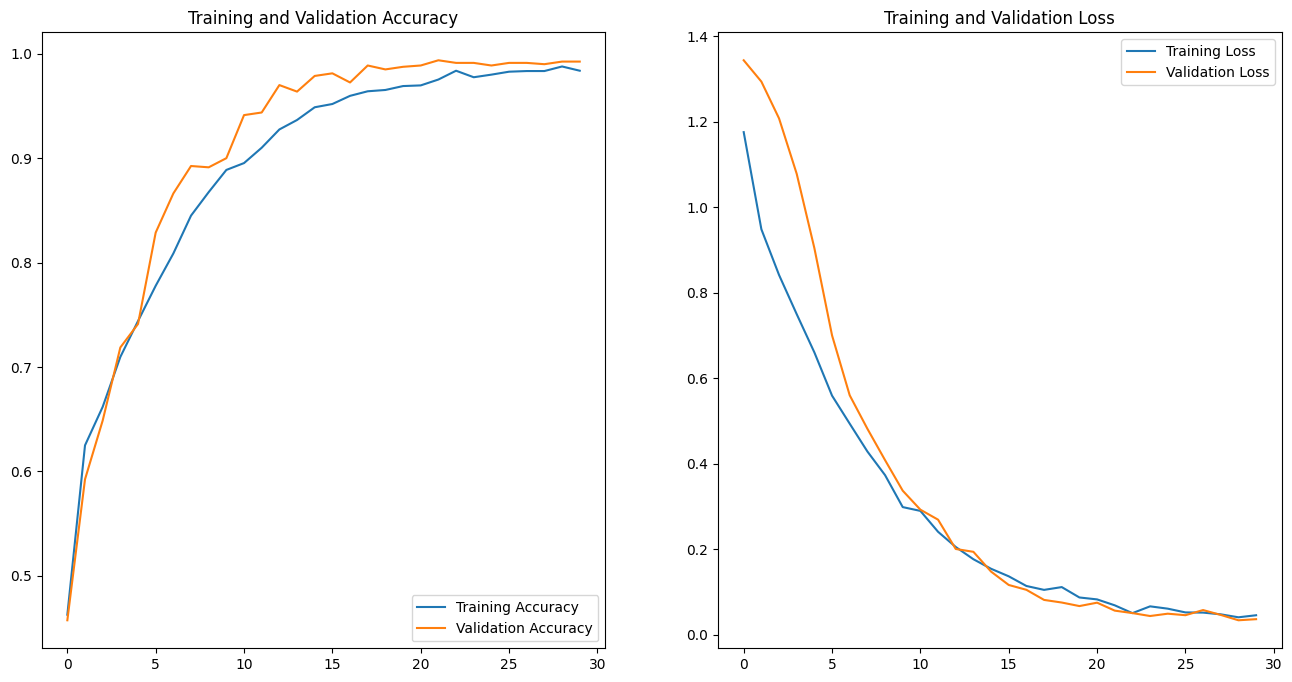

In [109]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

First image to predict
First image's actual label: Rot_Apple
Predicted label: Rot_Apple


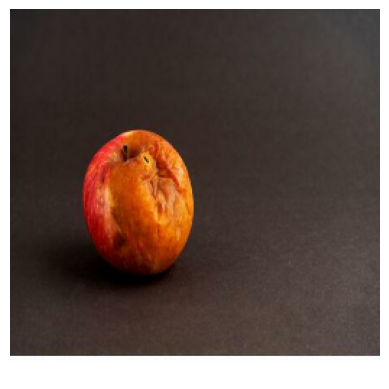

In [110]:
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    plt.axis("off")
    print("First image's actual label:", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted label:", class_names[np.argmax(batch_prediction[0])])
    # print(batch_prediction[0]) # input for np.argmax() above
    

In [111]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images_batch[i])
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    
    predictions = model.predict(img_array)
       
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence
                                  

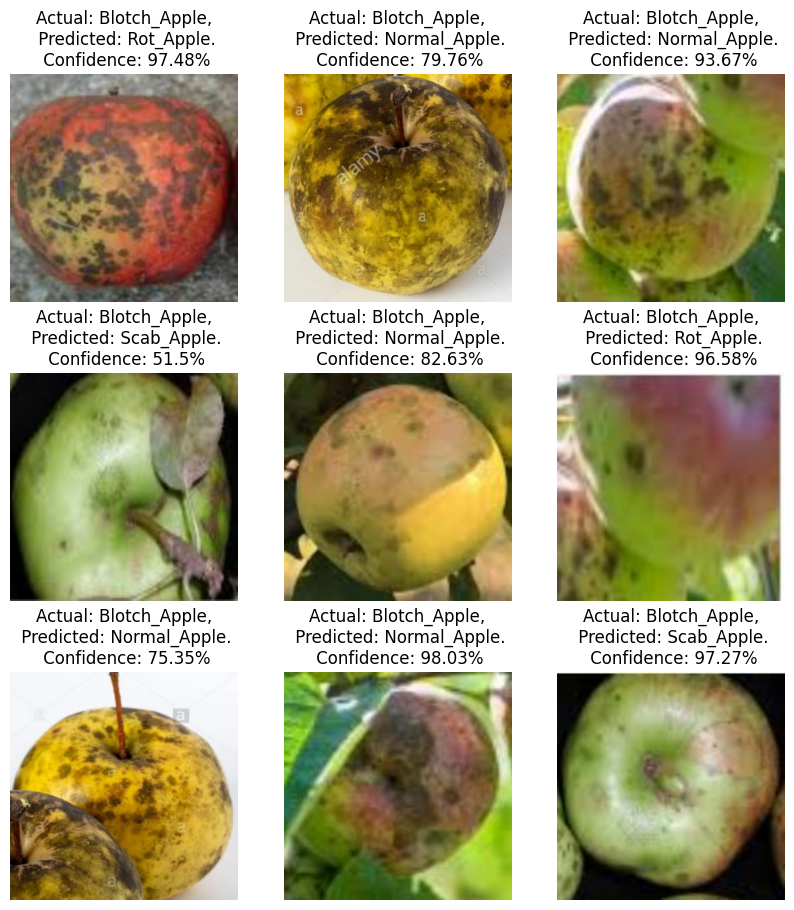

In [123]:
plt.figure(figsize=(10, 11))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy()) 
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [113]:
import os

model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}") # check ValueError: invalid literal for int() with base 10: '.gitkeep' <<<

INFO:tensorflow:Assets written to: ../models/33\assets


In [114]:
# model.save("..models/../apples.h5")

In [115]:
model.predict(test_ds)

array([[3.89480218e-02, 2.91540213e-02, 1.62492724e-04, 9.31735456e-01],
       [1.08625274e-03, 3.17489393e-02, 1.17158146e-04, 9.67047691e-01],
       [9.80485320e-01, 9.61775053e-03, 5.50682098e-03, 4.39016102e-03],
       [4.16339785e-02, 4.49305726e-03, 8.84248376e-01, 6.96245879e-02],
       [2.13832827e-03, 1.81445647e-02, 9.78829622e-01, 8.87514383e-04],
       [8.83657262e-02, 4.50779319e-01, 4.36084479e-01, 2.47704703e-02],
       [2.22519859e-07, 9.99996424e-01, 9.33691467e-07, 2.44098555e-06],
       [8.04940343e-01, 1.64469786e-03, 1.59056947e-01, 3.43579613e-02],
       [9.91456330e-01, 4.39974855e-07, 5.13720501e-04, 8.02946743e-03],
       [2.52080541e-02, 7.46870282e-05, 9.30406868e-01, 4.43103537e-02],
       [6.46502733e-01, 1.77333161e-04, 3.35270166e-02, 3.19792897e-01],
       [5.17268891e-05, 5.95847033e-02, 9.39652085e-01, 7.11380213e-04],
       [7.92760693e-04, 5.68419182e-06, 9.99136508e-01, 6.50015281e-05],
       [8.51645837e-06, 4.55830559e-06, 9.98964429e

Found 120 files belonging to 4 classes.


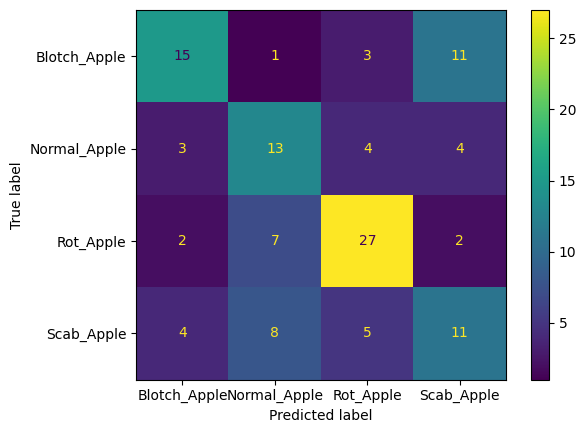

In [124]:

# herhaling test_ds met shuffle = False zorgt er voor dat de confusion matrix steeds dezelfde, correcte uitslag toont

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "../augmented_data/Test",
    seed = 123,
    shuffle = False,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

predictionBatch = model.predict(test_ds)
predictionEnhanced = tf.argmax(predictionBatch, axis=-1)
actualCategories = tf.concat([y for x, y in test_ds], axis=0)

confusionMatrix = metrics.confusion_matrix(actualCategories, predictionEnhanced)

cmDisplay = metrics.ConfusionMatrixDisplay(confusion_matrix = confusionMatrix, display_labels = ["Blotch_Apple", "Normal_Apple", "Rot_Apple", "Scab_Apple"])

cmDisplay.plot()

plt.show()

In [118]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 16904), started 5 days, 0:50:21 ago. (Use '!kill 16904' to kill it.)